In [10]:
# Cell 2 – imports & paths

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nibabel as nib
from nilearn import image, masking, plotting


PROJECT_ROOT = Path(".")
DATA_ROOT    = PROJECT_ROOT / "data"
DERIV_ROOT   = PROJECT_ROOT / "derivatives" / "music"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_ROOT exists:", DATA_ROOT.exists())
print("DERIV_ROOT exists:", DERIV_ROOT.exists())

PROJECT_ROOT: .
DATA_ROOT exists: True
DERIV_ROOT exists: True


In [11]:
# Cell 3 – locate run-02 BOLD images and the masks from Phase 1

bold_files = sorted(
    DATA_ROOT.glob("music/sub-*_task-Test_run-02_bold.nii*")
)

mask_files = sorted(
    DERIV_ROOT.glob("sub-*_run-02_mask.nii.gz")
)

print("Found run-02 BOLD files:", len(bold_files))
for f in bold_files:
    print("  BOLD:", f.name)

print("\nFound run-02 masks:", len(mask_files))
for f in mask_files:
    print("  MASK:", f.name)

if len(bold_files) == 0:
    raise FileNotFoundError("No run-02 BOLD files found – check DATA_ROOT.")

if len(mask_files) != len(bold_files):
    print("\nWARNING: number of masks != number of BOLD files.")

Found run-02 BOLD files: 5
  BOLD: sub-001_task-Test_run-02_bold.nii
  BOLD: sub-002_task-Test_run-02_bold.nii
  BOLD: sub-003_task-Test_run-02_bold.nii
  BOLD: sub-004_task-Test_run-02_bold.nii
  BOLD: sub-005_task-Test_run-02_bold.nii

Found run-02 masks: 5
  MASK: sub-001_run-02_mask.nii.gz
  MASK: sub-002_run-02_mask.nii.gz
  MASK: sub-003_run-02_mask.nii.gz
  MASK: sub-004_run-02_mask.nii.gz
  MASK: sub-005_run-02_mask.nii.gz


In [12]:
# Cell 4 – build a group-level mask (intersection of all run-02 masks)
# by first resampling all masks to a common reference grid.

if not mask_files:
    raise FileNotFoundError("No run-02 masks found in DERIV_ROOT.")

# Use the first mask as the reference grid
ref_mask_path = mask_files[0]
ref_mask_img = image.load_img(ref_mask_path)
print("Reference mask:", ref_mask_path.name, "shape:", ref_mask_img.shape)

resampled_masks = [ref_mask_img]

for mf in mask_files[1:]:
    m_img = image.load_img(mf)
    # If shape or affine differ, resample to the reference
    if (m_img.shape != ref_mask_img.shape) or not np.allclose(m_img.affine, ref_mask_img.affine):
        print("Resampling", mf.name, "to reference grid")
        m_img = image.resample_to_img(m_img, ref_mask_img, interpolation="nearest")
    else:
        print("Mask", mf.name, "already matches reference grid")
    resampled_masks.append(m_img)

# Now all masks are on the same grid → safe to intersect
group_mask_img = masking.intersect_masks(
    resampled_masks,
    threshold=1.0,   # voxels present in ALL subjects
    connected=True
)

group_mask_path = DERIV_ROOT / "group_run-02_mask_intersection.nii.gz"
group_mask_img.to_filename(group_mask_path)

print("Saved group mask to:", group_mask_path)

Reference mask: sub-001_run-02_mask.nii.gz shape: (96, 96, 68)
Resampling sub-002_run-02_mask.nii.gz to reference grid
Resampling sub-003_run-02_mask.nii.gz to reference grid
Resampling sub-004_run-02_mask.nii.gz to reference grid
Resampling sub-005_run-02_mask.nii.gz to reference grid


C:\Users\Nirwaan Azhar\AppData\Local\Temp\ipykernel_19936\4008361964.py:19: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  m_img = image.resample_to_img(m_img, ref_mask_img, interpolation="nearest")
C:\Users\Nirwaan Azhar\AppData\Local\Temp\ipykernel_19936\4008361964.py:19: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  m_img = image.resample_to_img(m_img, ref_mask_img, interpolation="nearest")
C:\Users\Nirwaan Azhar\AppData\Local\Temp\ipykernel_19936\4008361964.py:19: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  m_img = image.resample_to_img(m_img, ref_mask_img, interpolation="nearest")
C:\Us

Saved group mask to: derivatives\music\group_run-02_mask_intersection.nii.gz


C:\Users\Nirwaan Azhar\AppData\Local\Temp\ipykernel_19936\3052249373.py:5: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  example_mean = image.mean_img(example_bold)


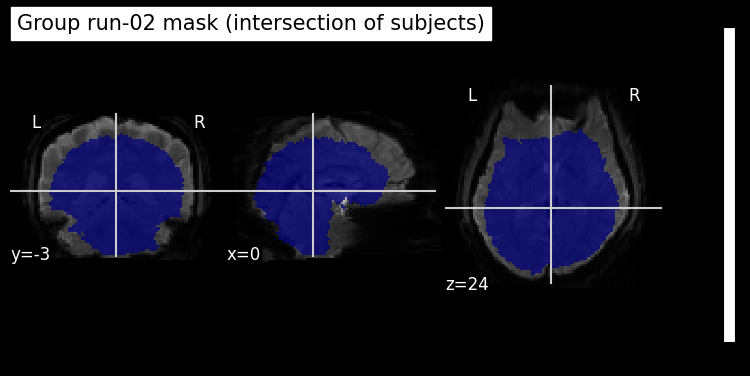

In [13]:
# Cell 5 – visualize the group-level mask on top of one subject's mean EPI

# use first subject as background
example_bold = image.load_img(bold_files[0])
example_mean = image.mean_img(example_bold)

plotting.plot_roi(
    group_mask_img,
    bg_img=example_mean,
    title="Group run-02 mask (intersection of subjects)"
)

In [14]:
# Cell 6 – compute tSNR maps per subject for run-02
# using each subject's own run-02 mask (native space)

from nilearn import masking
import numpy as np

# Map subject -> its run-02 mask
mask_dict = {}
for mf in mask_files:
    sub_id = mf.name.split("_")[0]   # "sub-001"
    mask_dict[sub_id] = mf

print("Subject -> mask mapping:")
for k, v in mask_dict.items():
    print(" ", k, "->", v.name)


def compute_tsnr_for_run_native(bold_path: Path, mask_path: Path, out_dir: Path):
    """
    Compute temporal SNR for one run using the subject's own mask.
    tSNR = mean(signal over time) / std(signal over time)
    """
    sub_id = bold_path.name.split("_")[0]
    print(f"\nComputing tSNR for {sub_id} ({bold_path.name})")
    print("  Using mask:", mask_path.name)

    img = image.load_img(bold_path)
    mask_img = image.load_img(mask_path)

    # Sanity check: if affine/shape differ a bit, resample mask to BOLD
    if (img.shape[:3] != mask_img.shape[:3]) or not np.allclose(img.affine, mask_img.affine):
        print("  Resampling mask to match BOLD grid")
        mask_img = image.resample_to_img(mask_img, img, interpolation="nearest")

    # Apply mask: result is (n_scans, n_voxels)
    data_2d = masking.apply_mask(img, mask_img)

    mean_ts = data_2d.mean(axis=0)
    std_ts  = data_2d.std(axis=0)

    tsnr_1d = np.divide(
        mean_ts,
        std_ts,
        out=np.zeros_like(mean_ts),
        where=std_ts > 0
    )

    # Back to 3D in this subject's native space
    tsnr_img = masking.unmask(tsnr_1d, mask_img)

    out_path = out_dir / f"{sub_id}_run-02_tsnr_native.nii.gz"
    tsnr_img.to_filename(out_path)
    print("  Saved tSNR map to:", out_path)

    median_tsnr = float(np.median(tsnr_1d))
    mean_tsnr   = float(np.mean(tsnr_1d))

    return {
        "subject": sub_id,
        "run": "run-02",
        "median_tsnr": median_tsnr,
        "mean_tsnr": mean_tsnr,
    }


tsnr_summaries = []

for bold_path in bold_files:
    sub_id = bold_path.name.split("_")[0]
    if sub_id not in mask_dict:
        print(f"WARNING: no mask found for {sub_id}, skipping.")
        continue

    mask_path = mask_dict[sub_id]
    info = compute_tsnr_for_run_native(bold_path, mask_path, DERIV_ROOT)
    tsnr_summaries.append(info)

print("\nFinished computing native-space tSNR for", len(tsnr_summaries), "run-02 files.")

Subject -> mask mapping:
  sub-001 -> sub-001_run-02_mask.nii.gz
  sub-002 -> sub-002_run-02_mask.nii.gz
  sub-003 -> sub-003_run-02_mask.nii.gz
  sub-004 -> sub-004_run-02_mask.nii.gz
  sub-005 -> sub-005_run-02_mask.nii.gz

Computing tSNR for sub-001 (sub-001_task-Test_run-02_bold.nii)
  Using mask: sub-001_run-02_mask.nii.gz
  Saved tSNR map to: derivatives\music\sub-001_run-02_tsnr_native.nii.gz

Computing tSNR for sub-002 (sub-002_task-Test_run-02_bold.nii)
  Using mask: sub-002_run-02_mask.nii.gz
  Saved tSNR map to: derivatives\music\sub-002_run-02_tsnr_native.nii.gz

Computing tSNR for sub-003 (sub-003_task-Test_run-02_bold.nii)
  Using mask: sub-003_run-02_mask.nii.gz
  Saved tSNR map to: derivatives\music\sub-003_run-02_tsnr_native.nii.gz

Computing tSNR for sub-004 (sub-004_task-Test_run-02_bold.nii)
  Using mask: sub-004_run-02_mask.nii.gz
  Saved tSNR map to: derivatives\music\sub-004_run-02_tsnr_native.nii.gz

Computing tSNR for sub-005 (sub-005_task-Test_run-02_bold.nii)

C:\Users\Nirwaan Azhar\AppData\Local\Temp\ipykernel_19936\3627637655.py:5: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  example_mean = image.mean_img(example_bold)


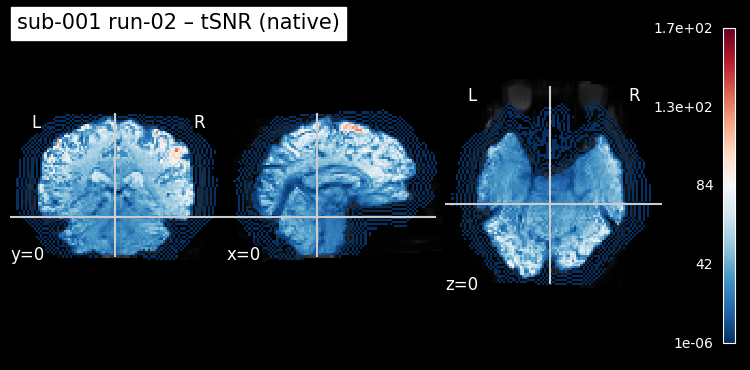

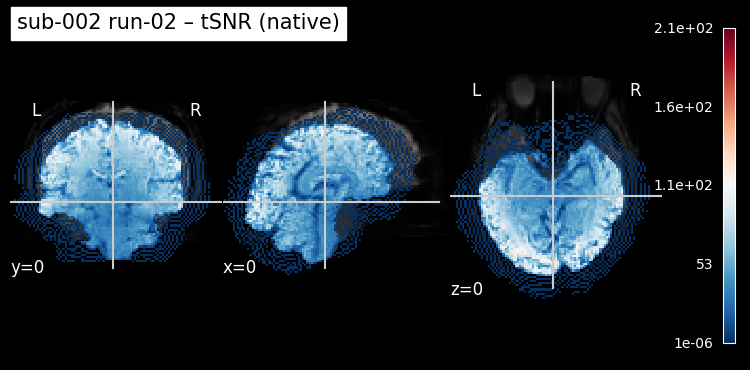

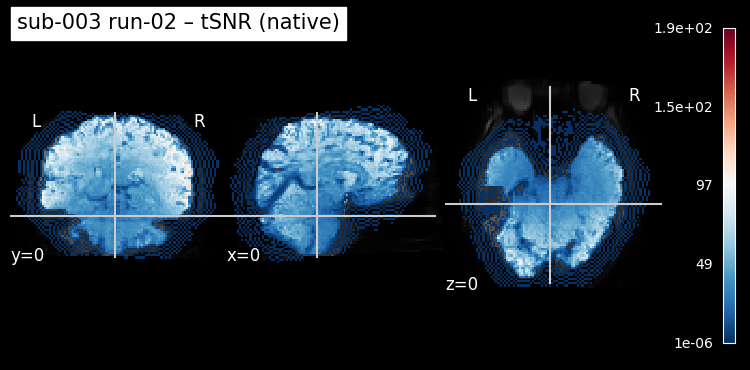

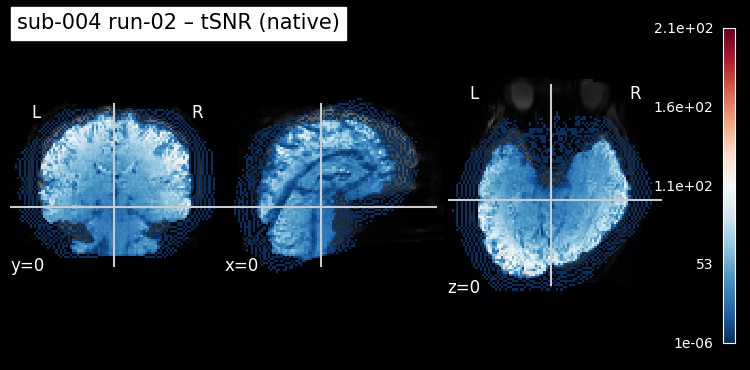

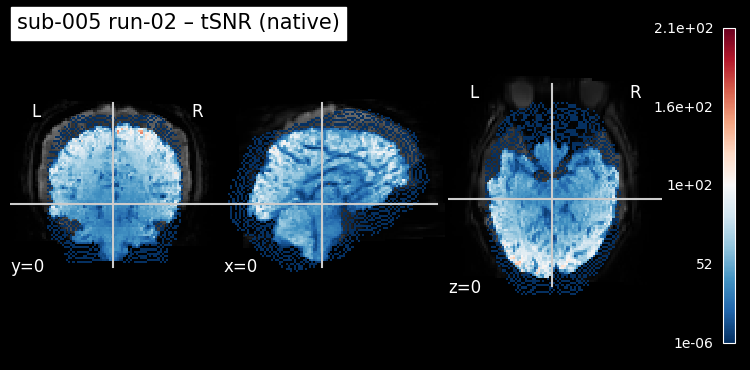

In [15]:
# Cell 7 – quick tSNR plots for each subject (native-space tSNR)

# Make sure we have a background mean image from one subject
example_bold = image.load_img(bold_files[0])
example_mean = image.mean_img(example_bold)

for bold_path in bold_files:
    sub_id = bold_path.name.split("_")[0]
    tsnr_path = DERIV_ROOT / f"{sub_id}_run-02_tsnr_native.nii.gz"  # <-- match Cell 6

    if not tsnr_path.exists():
        print(f"tSNR file missing for {sub_id}: {tsnr_path.name}")
        continue

    tsnr_img = image.load_img(tsnr_path)

    plotting.plot_stat_map(
        tsnr_img,
        bg_img=example_mean,
        title=f"{sub_id} run-02 – tSNR (native)",
        display_mode="ortho",
        cut_coords=(0, 0, 0),
    )

C:\Users\Nirwaan Azhar\AppData\Local\Temp\ipykernel_19936\3574769804.py:27: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  img_res = image.resample_to_img(img, ref_tsnr, interpolation="continuous")
C:\Users\Nirwaan Azhar\AppData\Local\Temp\ipykernel_19936\3574769804.py:27: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_res = image.resample_to_img(img, ref_tsnr, interpolation="continuous")
C:\Users\Nirwaan Azhar\AppData\Local\Temp\ipykernel_19936\3574769804.py:27: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  img_res = image.resample_to_img(img, ref_tsnr, interpolation="continuous")
C:\Users

Saved group-average tSNR map to: derivatives\music\group_run-02_tsnr_mean.nii.gz


,subject,run,median_tsnr,mean_tsnr
0,sub-001,run-02,44.045017,44.977207
1,sub-002,run-02,55.748623,56.472492
2,sub-003,run-02,51.868324,52.538658
3,sub-004,run-02,53.254009,53.777348
4,sub-005,run-02,59.049526,59.431221


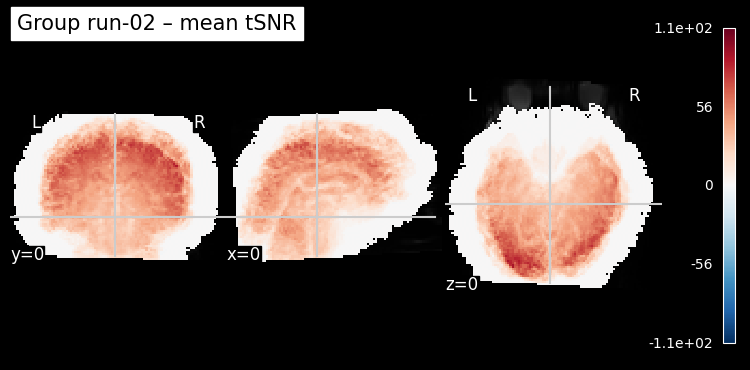

In [16]:
# Cell 8 – group-average tSNR map and subject summary table (native-space tSNR)

from nilearn import image
import numpy as np
import pandas as pd

# 1) Load all subject tSNR maps (native-space)
tsnr_imgs_native = []
for bold_path in bold_files:
    sub_id = bold_path.name.split("_")[0]
    tsnr_path = DERIV_ROOT / f"{sub_id}_run-02_tsnr_native.nii.gz"

    if not tsnr_path.exists():
        print(f"Missing tSNR file for {sub_id}: {tsnr_path.name}")
        continue

    tsnr_imgs_native.append(image.load_img(tsnr_path))

if not tsnr_imgs_native:
    raise RuntimeError("No tSNR maps found – check Cell 6.")

# 2) Resample all tSNR maps to the first subject's grid (just in case)
ref_tsnr = tsnr_imgs_native[0]
resampled_tsnr = []
for img in tsnr_imgs_native:
    if (img.shape != ref_tsnr.shape) or not np.allclose(img.affine, ref_tsnr.affine):
        img_res = image.resample_to_img(img, ref_tsnr, interpolation="continuous")
        resampled_tsnr.append(img_res)
    else:
        resampled_tsnr.append(img)

# 3) Compute group-average tSNR
group_tsnr_img = image.mean_img(resampled_tsnr)
group_tsnr_path = DERIV_ROOT / "group_run-02_tsnr_mean.nii.gz"
group_tsnr_img.to_filename(group_tsnr_path)
print("Saved group-average tSNR map to:", group_tsnr_path)

# Reuse example_mean from Cell 7 (or recompute if needed)
plotting.plot_stat_map(
    group_tsnr_img,
    bg_img=example_mean,
    title="Group run-02 – mean tSNR",
    display_mode="ortho",
    cut_coords=(0, 0, 0),
)

# 4) Subject-level summary table (from tsnr_summaries in Cell 6)
tsnr_df = pd.DataFrame(tsnr_summaries).sort_values("subject")
display(tsnr_df)